The nature of distance functions require us to be aware of generic structure assigned by the Kernel functions such as the RBF
https://www.cs.toronto.edu/~duvenaud/thesis.pdf

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
plt.rcParams.update({"text.usetex": True,
                     "axes.spines.right" : False,
                     "axes.spines.top" : False,
                     "font.size": 18
                    }
                   )

from gpytorch.means import ConstantMean
from gpytorch.distributions import MultivariateNormal
import torch
import pdb
from gpytorch import kernels
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.models import ExactGP

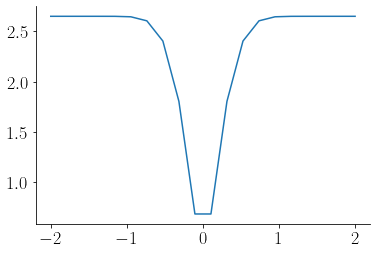

In [3]:
lambda_ = np.linspace(-5,5,num=100)
def gaussian(a, b,c):
    return a*np.exp(-np.power(lambda_ - b, 2.) / (2 * np.power(c, 2.)))

x = np.linspace(-2,2,num=20)
phi_x = [gaussian(1,xi,0.2) for xi in x]
phi_xt = gaussian(1,0,0.2)
fx = [distance.euclidean(phi_xi, phi_xt) for phi_xi in phi_x]

fig, ax = plt.subplots()
ax.plot(x, fx)
plt.show()

In [4]:
class ChangePointKernel(kernels.Kernel):
    is_stationary = False

    def forward(self,x1,x2, **params):
        k1 = kernels.ScaleKernel(kernels.RBFKernel())
        k2 = kernels.LinearKernel()
        sx1 = 1./(1+torch.exp(-torch.inner(x1,x1))) + 1e-20
        sx2 = 1./(1+torch.exp(-torch.inner(x2,x2))) + 1e-20
        
        t1 = sx1*k1.forward(x1,x2,**params)*sx2
        t2 = (1-sx1)*k2.forward(x1,x2,**params)*(1-sx2)
        
        return t1+t2

/Users/pozzolabadmin/Documents/codebase/HEAD/env/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


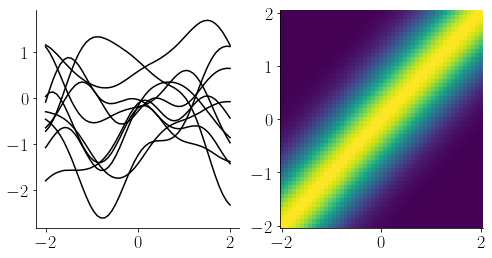

In [5]:
# check if we can sample these set of functions from simple SE covariance

def GP(x):
    mean_module = ConstantMean()
    covar_module = kernels.RBFKernel()
    mean_x = mean_module(x)
    covar_x = covar_module(x)
    return MultivariateNormal(mean_x, covar_x)
    
x_torch = torch.from_numpy(x.astype(np.float32))  
test_x = torch.linspace(-2, 2, 51)
dist = GP(test_x)
samples = dist.sample(torch.Size([10]))
fig, axs = plt.subplots(1,2,figsize=(4*2,4))
for si in samples:
    axs[0].plot(test_x, si,color='k')
axs[1].pcolormesh(test_x,test_x.T, dist.covariance_matrix, shading='auto')
plt.show()

In [6]:
class GPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = GaussianLikelihood()
y_torch = torch.from_numpy(np.asarray(fx).astype(np.float32))
model = GPModel(x_torch, y_torch, likelihood)

In [7]:
import gpytorch
num_iter = 100 
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1) 
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(num_iter):
    optimizer.zero_grad()
    output = model(x_torch)
    loss = -mll(output, y_torch)
    loss.backward()
    if not i%10:
        print('Iter %d/%d - Loss: %.3f' % (i + 1, num_iter, loss.item()))
    optimizer.step()

Iter 1/100 - Loss: 1.463
Iter 11/100 - Loss: 1.013
Iter 21/100 - Loss: 0.823
Iter 31/100 - Loss: 0.567
Iter 41/100 - Loss: 0.419
Iter 51/100 - Loss: 0.304
Iter 61/100 - Loss: 0.248
Iter 71/100 - Loss: 0.216
Iter 81/100 - Loss: 0.201
Iter 91/100 - Loss: 0.194


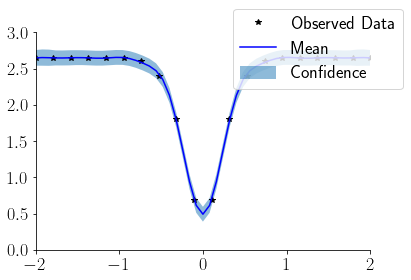

In [8]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    
with torch.no_grad():
    fig, ax = plt.subplots()
    lower, upper = observed_pred.confidence_region()
    ax.plot(x_torch.numpy(), y_torch.numpy(), 'k*')
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    fig.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_xlim([-2,2])
    ax.set_ylim([0,3])

/Users/pozzolabadmin/Documents/codebase/HEAD/env/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Users/pozzolabadmin/Documents/codebase/HEAD/env/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


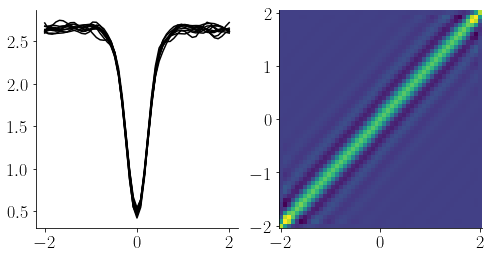

In [9]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    posterior = model(test_x)
    samples = posterior.sample(torch.Size([10]))
    fig, axs = plt.subplots(1,2,figsize=(4*2,4))
    for si in samples:
        axs[0].plot(test_x, si,color='k')
    axs[1].pcolormesh(test_x,test_x.T, posterior.covariance_matrix, shading='auto')
    plt.show()